<a href="https://colab.research.google.com/github/theboredman/CSE468/blob/main/Quiz_1/CNN/Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN (CIFAR 10 Dataset)

## Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Prepare the data

In [2]:
num_classes = 10
input_shape = (3, 32, 32)  # PyTorch uses (channels, height, width)

# Define transforms for data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Training samples: 50000
Test samples: 10000


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 20

# Additional hyperparameters
dropout_rate = 0.3


## Use data augmentation

In [4]:
# Data augmentation is handled in the transforms defined earlier
# PyTorch transforms are applied during data loading
print("Data augmentation configured in the DataLoader transforms")

Data augmentation configured in the DataLoader transforms


## Implement multilayer perceptron (MLP)

In [5]:
# MLP helper class for PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        in_features = input_dim
        for units in hidden_units:
            layers.append(nn.Linear(in_features, units))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = units
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


## CNN Architecture

We'll build a CNN with convolutional layers for feature extraction followed by dense layers for classification.

In [6]:
# CNN Architecture in PyTorch
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

        # Dense layers
        self.fc1 = nn.Linear(512 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)

        # MLP head
        self.mlp = MLP(512, [2048, 1024], dropout_rate=0.5)

        # Final classifier
        self.fc_out = nn.Linear(1024, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial conv
        out = torch.relu(self.bn1(self.conv1(x)))

        # Residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Global pooling (both avg and max)
        avg_out = self.avgpool(out)
        max_out = self.maxpool(out)
        out = torch.cat([avg_out, max_out], dim=1)
        out = out.view(out.size(0), -1)

        # Dense layers
        out = torch.relu(self.bn_fc1(self.fc1(out)))
        out = self.dropout1(out)

        out = torch.relu(self.bn_fc2(self.fc2(out)))
        out = self.dropout2(out)

        # MLP head
        out = self.mlp(out)

        # Final output
        out = self.fc_out(out)
        return out


# Create model instance
model = CNNClassifier(num_classes=num_classes).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")


Model created with 17,381,450 parameters


## Compile, train, and evaluate the model

Model Architecture:
CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64,

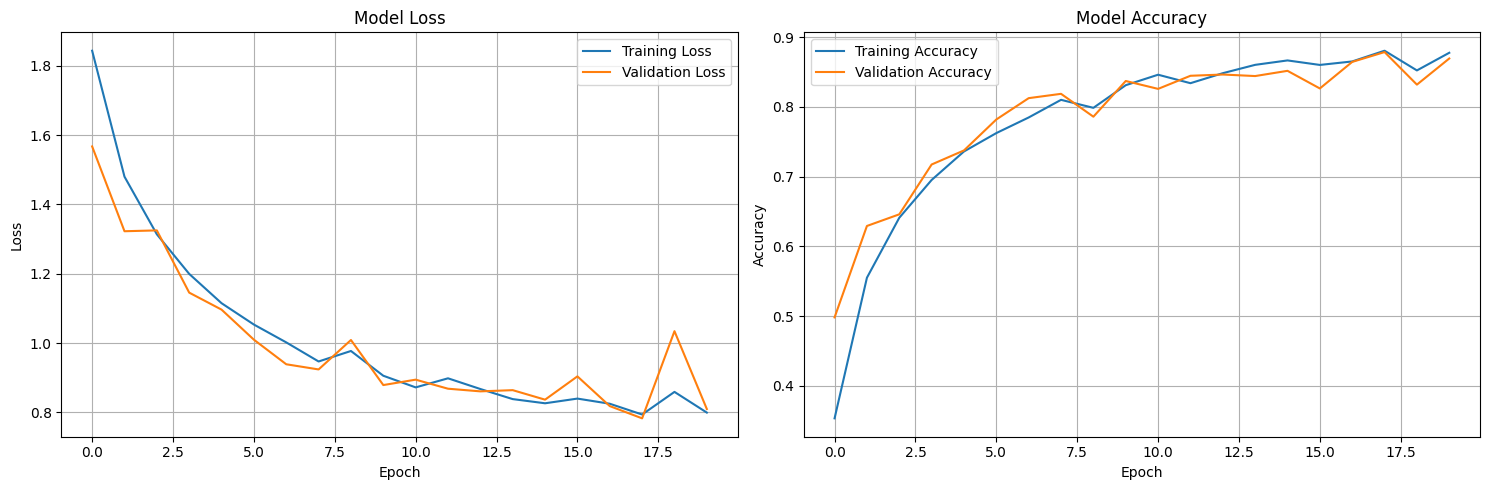

In [9]:
def warmup_cosine_decay_scheduler(epoch):
    """Learning rate scheduler with warmup and cosine decay"""
    # Need to define warmup_epochs and initial_learning_rate or use the existing ones
    warmup_epochs = 5 # Example value, adjust as needed
    initial_learning_rate = learning_rate # Using the defined learning_rate
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_learning_rate * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return initial_learning_rate * 0.5 * (1 + np.cos(np.pi * progress))


def run_experiment(model, trainloader, testloader, num_epochs, learning_rate, weight_decay):
    # Use AdamW with better parameters
    # Need to use torch.optim.AdamW
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-7
    )

    # Apply label smoothing to y_train
    # Label smoothing is typically applied within the loss function in PyTorch
    # y_train_smoothed = keras.utils.to_categorical(y_train, num_classes=num_classes)
    # y_train_smoothed = y_train_smoothed * (1 - label_smoothing) + label_smoothing / num_classes
    label_smoothing = 0.1 # Example value, adjust as needed


    # Compile with label smoothing
    # Need to define a loss function and metrics in PyTorch
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing) # CrossEntropyLoss supports label_smoothing in recent PyTorch versions

    # Get callbacks
    # callbacks = create_callbacks() # Commented out as this is Keras specific

    # Train the model
    # Need to implement the training loop in PyTorch
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []} # Placeholder for history

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            correct_predictions += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = correct_predictions / total_samples
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        # Validation loop (simplified)
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        with torch.no_grad():
            for inputs, labels in testloader: # Using testloader for validation
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total_samples += labels.size(0)
                val_correct_predictions += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(testloader)
        val_epoch_accuracy = val_correct_predictions / val_total_samples
        history['val_loss'].append(val_epoch_loss)
        history['val_accuracy'].append(val_epoch_accuracy)


        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")


    # Load best weights
    # Need to implement model checkpointing and loading in PyTorch if desired
    # model.load_weights("/tmp/best_model.weights.h5")

    # Evaluate on test set
    # The validation loop above is essentially the test evaluation in this simplified version
    test_loss = val_epoch_loss
    accuracy = val_epoch_accuracy
    # Need to calculate top 5 accuracy in PyTorch if required
    top_5_accuracy = 0 # Placeholder

    print(f"\nFinal Test Results:")
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    print(f"Test loss: {round(test_loss, 4)}")


    return history


# Create and train the enhanced model
# Use the defined CNNClassifier class
cnn_classifier = CNNClassifier(num_classes=num_classes).to(device)


# Print model summary
# Need to use torchsummary or print the model structure
print("Model Architecture:")
print(cnn_classifier)

# Train the model
history = run_experiment(cnn_classifier, trainloader, testloader, num_epochs, learning_rate, weight_decay)


def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Adjusted for available data

    # Plot loss
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy
    axes[1].plot(history['accuracy'], label='Training Accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)


    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)